In [1100]:
%matplotlib inline
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score 
from sklearn.metrics import confusion_matrix
import pickle
from scipy.stats import zscore
from collections import Counter


In [1101]:
#variables
K = range(2,11)
inertias = {}
silhouette_scores = {}
#potential categories: good, average, poor
n_clusters = 4
n_init = 10


In [1102]:
#dataset used: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset
#load data
data = pd.read_csv("data\Student_performance_data _.csv")

print(data.head)
#print(data.columns)
data = data.drop("StudentID", axis=1)



<bound method NDFrame.head of       StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0          1001   17       1          0                  2        19.833723   
1          1002   18       0          0                  1        15.408756   
2          1003   15       0          2                  3         4.210570   
3          1004   17       1          0                  3        10.028829   
4          1005   17       1          0                  2         4.672495   
...         ...  ...     ...        ...                ...              ...   
2387       3388   18       1          0                  3        10.680555   
2388       3389   17       0          0                  1         7.583217   
2389       3390   16       1          0                  2         6.805500   
2390       3391   16       1          1                  0        12.416653   
2391       3392   16       1          0                  2        17.819907   

      Absences  Tutor

In [1103]:
#preprocess data
#assuming GradeClass is the target

#categorical_cols = ["Gender", "Ethnicity", "ParentalEducation", "Tutoring", "ParentalSupport", "Extracurricular", "Sports", "Music", "Volunteering"]
#data = pd.get_dummies(data, columns=categorical_cols)
#data = data.drop(columns=categorical_cols, axis=1)
X = data.copy()

features = ['Age', 'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'GPA']

X = data[features]
X = pd.get_dummies(X, columns=["Tutoring", "ParentalSupport"])
correlation_matrix = X.corr()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

X = X.select_dtypes(include=[np.number])
X = X.dropna()
X = X[(np.abs(zscore(X)) < 3).all(axis=1)]

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

#print(X_normalized)

In [1104]:
#finding optimal parameters using lebow method
for k in K:
    model = KMeans(n_clusters = k, random_state=1, n_init = 100, max_iter = 1000)
    model.fit(X_normalized)
    inertias[k] = model.inertia_
    silhouette_scores[k] = silhouette_score(X_normalized, model.labels_)

#for i in K:
    #print(str(i) + ": " + str(inertias[i]))

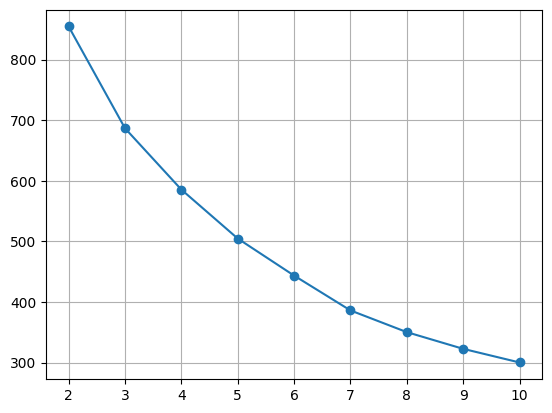

In [1105]:
#plotting inertias
#print(inertia_vals)
plt.plot(K, list(inertias.values()), linestyle="-", marker="o")
plt.xlabel=("Number of clusters")
plt.ylabel=("Inertia")
plt.grid(True)

plt.show()


In [1106]:
#K means training
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
optimal_k = 8
print(f"Optimal k: {optimal_k}")
k_model = KMeans(n_clusters = optimal_k, random_state=1, init="k-means++", n_init=100, max_iter = 1000)
k_model.fit(X_normalized)
data["Cluster"] = k_model.labels_ 
#y_km = k_model.predict(X_normalized)

Optimal k: 8


In [1107]:
# Cluster profile: Summarize characteristics of each cluster
for i in range(k_model.n_clusters):
    print(f"\nCluster {i}:")
    cluster_data = data[data["Cluster"] == i]
    print(cluster_data.describe())


Cluster 0:
              Age      Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
count  216.000000  216.000000   216.0000         216.000000       216.000000   
mean    17.527778    0.467593     0.7500           1.814815         9.042031   
std      0.500387    0.500108     0.9413           0.994386         5.899867   
min     17.000000    0.000000     0.0000           0.000000         0.014337   
25%     17.000000    0.000000     0.0000           1.000000         3.983485   
50%     18.000000    0.000000     0.0000           2.000000         8.603058   
75%     18.000000    1.000000     1.0000           2.000000        14.196759   
max     18.000000    1.000000     3.0000           4.000000        19.856080   

         Absences    Tutoring  ParentalSupport  Extracurricular      Sports  \
count  216.000000  216.000000       216.000000            216.0  216.000000   
mean    21.421296    0.273148         2.069444              1.0    0.282407   
std      4.451633    0.446611 

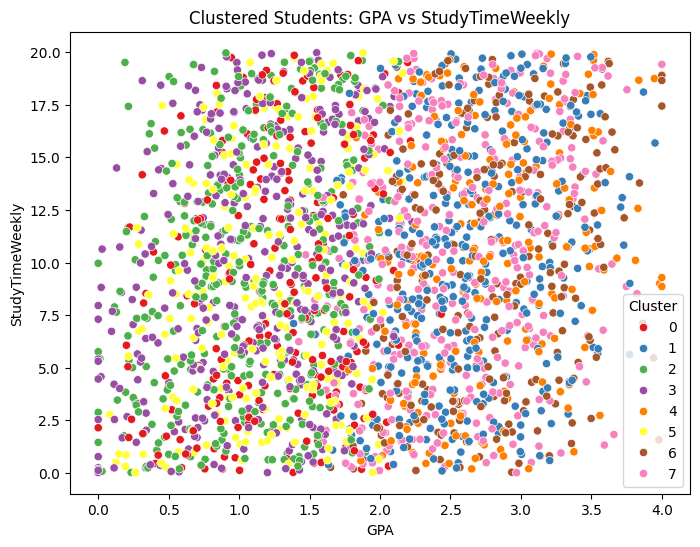

In [1108]:
# Visualize the clusters

df_clustered = pd.DataFrame(X_normalized, columns=X.columns)
df_clustered["Cluster"] = data["Cluster"]

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=data["GPA"], y=data["StudyTimeWeekly"], hue=data["Cluster"], palette="Set1", ax=axes)
axes.set_title("Clustered Students: GPA vs StudyTimeWeekly")
axes.set_xlabel("GPA")
axes.set_ylabel("StudyTimeWeekly")

plt.show()


In [1109]:
#silhouette scores
cluster_score = silhouette_score(X_normalized, k_model.fit_predict(X_normalized))
print(cluster_score)



0.2921092963561439


In [1110]:
print(Counter(k_model.labels_))

Counter({2: 371, 7: 371, 3: 367, 1: 366, 6: 244, 5: 241, 4: 216, 0: 216})


In [1111]:
centroids = pd.DataFrame(k_model.cluster_centers_, columns=X.columns)
print(centroids)

        Age  StudyTimeWeekly  Absences  Extracurricular       GPA
0  0.842593         0.452568  0.738665     1.000000e+00  0.322558
1  0.824226         0.503148  0.244394     0.000000e+00  0.652200
2  0.844564         0.468626  0.745887     0.000000e+00  0.269413
3  0.164396         0.491753  0.749789    -5.551115e-17  0.275744
4  0.816358         0.516390  0.253672     1.000000e+00  0.693344
5  0.167358         0.459236  0.771355     1.000000e+00  0.302597
6  0.161202         0.495985  0.244630     1.000000e+00  0.695327
7  0.155436         0.513397  0.264523     5.551115e-17  0.641573


In [1112]:
#save model
path = "models/kmeans_model.h5"
try:
    with open(path, "wb") as f:
        pickle.dump(k_model, f)
except Exception as e:
    print(f"Error with saving model: {e}")

In [ ]:
#test prediction
pred = k_model.predict(np.array([0, 0, 0, 0, 0]).reshape(1, -1))
print(type(pred))
print(pred[0])
#Cluster 0, 2, 3, 5: Low performing, Cluster 1, 4: High performing

<class 'numpy.ndarray'>
7
